# IBM Data Science Course Capstone Project




# Background and Problem:
      
####          Eateries, with a 60 percent fail rate in the first year, are one of the most challenging businesses. There is a high upfront start up cost as well as significant competition from the nearby establishments. In order to increase the likelihood of a successful investment, a venture capital firm, interested in investing in a food place in Toronto, has tasked me with researching for the same. After much thought I have decided to determine the locations and categories of the most popular eateries in Toronto with the assumption they would have some correlation with potential success.

# Data acquisition:
       
####       The link https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&direction=prev&oldid=926287641 contains information related to the various neighborhoods of toronto.
   
####         Foursquare will serve as the source of information related to restaurants in the various neighborhoods of Toronto.

####         Geopy will provide location specifics(longitude, latitude).


### Importing libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from PIL import Image
import matplotlib.patches as mpatches

%matplotlib notebook

import scipy.stats as stats
from matplotlib import pyplot as plt
from matplotlib import rcParams
!conda install -c conda-forge geopy --yes
!pip install geocoder

from geopy.geocoders import Nominatim 
import geocoder

import requests 
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
!pip install folium
import folium

# import the library we use to open URLs
import urllib.request

from bs4 import BeautifulSoup

print('Libraries imported.')


Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


In [2]:
from PIL import Image
import matplotlib.patches as mpatches
!pip install seaborn
import seaborn

# Scraping wikipedia page of toronto postal codes to acquire location details

In [156]:
url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&direction=prev&oldid=926287641'

# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "lxml")
all_tables = soup.find_all("table")
right_table=soup.find('table', class_='wikitable sortable')
right_table

<table class="wikitable sortable">
<tbody><tr>
<th>Postcode</th>
<th>Borough</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
</td></tr>
<tr>
<td>M4A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a class="mw-redirect" href="/wiki/Harbourfront_(Toronto)" title="Harbourfront (Toronto)">Harbourfront</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Regent_Park" title="Regent Park">Regent Park</a>
</td></t

# Preparations to convert data into a Dataframe

In [157]:
A=[]
B=[]
C=[]

for row in right_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==3:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))


In [158]:
df_toronto=pd.DataFrame(A,columns=['PostalCode'])
df_toronto['Borough']=B
df_toronto['Neighborhood']=C
# remove \n values found in PostalCode
df_toronto['PostalCode']=df_toronto['PostalCode'].replace('\n','', regex=True)
df_toronto['Borough']=df_toronto['Borough'].replace('\n','', regex=True)
df_toronto['Neighborhood']=df_toronto['Neighborhood'].replace('\n','', regex=True)
df_toronto.drop(df_toronto[df_toronto['Borough'] == 'Not assigned'].index, axis=0,inplace=True)
print(df_toronto.shape)
df_toronto.head()
df_toronto.reset_index(drop=True).head()
                        


(211, 3)


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


# Adding Latitude and Longitude values to df_toronto

In [159]:
locgeo_df=pd.read_csv('https://cocl.us/Geospatial_data')
locgeo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [160]:
# Mergin the locgeo_df and df_toronto tables

In [161]:
locgeo_df.rename(columns={'Postal Code':'PostalCode'},inplace=True)
toronto_data=pd.merge(df_toronto,locgeo_df,on='PostalCode')
print(toronto_data.shape)
toronto_data.head()

(211, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


# Acquiring latitude and longitude values of toronto

In [162]:
address='Toronto,Ontario,Canada'
geolocator=Nominatim(user_agent='to_explorer')
location=geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
print('The geographical coordinate of Toronto are {},{}'.format(latitude,longitude))

The geographical coordinate of Toronto are 43.6534817,-79.3839347


# Creating a map of Toronto

In [163]:
toronto_map=folium.Map(location=[latitude,longitude],zoom_start=10)

for lat,lng,borough,neighborhood,postal_code in zip(toronto_data['Latitude'],toronto_data['Longitude'],toronto_data['Borough'],toronto_data['Neighborhood'],toronto_data['PostalCode']):
    label='{},{}'.format(postal_code,borough)
    label=folium.Popup(label,parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)

toronto_map

In [174]:
#CLIENT_ID = '5IT5KQ1AMORPEOU23N3B4ABOLM3ZJFFMQZ42QHUPJSPKZHUI' # your Foursquare ID
#CLIENT_SECRET = 'BEUC3MHNXS14PKHXG0VZU3WM3GUMGFRCKNHMRG5ZNIIEJY5C' # your Foursquare Secret
ACCESS_TOKEN='DDYR1FBYWHLN3GKYJBTX3VADDFKEYHC2NVYPMWQILAB4PI5C'
VERSION = '20180605' # Foursquare API version
LIMIT=100
CLIENT_ID='P5OREIYGD14WKVMGULES4CNMPXVWW0ATFMGFKWUSKCOTIUUR'
CLIENT_SECRET='TZ2AWM35NACQDXLOYGVG0TAB4IDTNWSD5EMWAZSXV4ENAJZQ'

# Explore each neighborhood's eateries in Toronto

### Create a function to extract the venue details from each Neighborhood

In [175]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):  
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&oauth_token={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            ACCESS_TOKEN,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue ID','Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [176]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']                                   
                                  )

# Size of Data Frame Toronto_Venues

In [177]:

print(toronto_venues.shape)
toronto_venues.assign(ColName='Rating')
toronto_venues.head()

(6058, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,58d5b8d0102f4722b70e487b,Careful & Reliable Painting,43.752622,-79.331957,Construction & Landscaping
2,Parkwoods,43.753259,-79.329656,51d769f2498e3efc78bee6b9,649 Variety,43.754513,-79.331942,Convenience Store
3,Parkwoods,43.753259,-79.329656,5fc825cac5b8dd60907c56b3,Towns On The Ravine,43.754754,-79.332552,Hotel
4,Parkwoods,43.753259,-79.329656,58f01a208f2c1a558cea5f7d,Sun Life,43.754760,-79.332783,Construction & Landscaping


## Exploring rating of each venue

In [178]:
def venue_info(df, start_index, end_index, v=20180405):
    responses = []
    print("Beginning Data Retrieval")
    print("-------------------------------")
    
    #start_index = 0 # index from which we begin polling venue information due to rate limited
    #end_index = 0 # index at which we stop polling, or earlier if failure returned from 4sq

    for index in range(start_index, end_index):
        id = toronto_venues.loc[index,"Venue ID"]
        print ('Attempting to get information for venue with id = ', id)
        
        url = f"https://api.foursquare.com/v2/venues/{id}?&v={v}&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}"
        
        response = requests.get(url)
        
        if response.status_code != 200:
            print ('Failure response from Foursquare API, breaking...')
            break
        else:
            result = response.json()['response']
            responses.append(result)
            try:
                toronto_venues.loc[index,"Rating"]=result['venue']['rating']
            except:
                toronto_venues.loc[index,"Rating"]="N/A"

    print("Data Retrieval Complete")

In [179]:
venue_info(toronto_venues, 0, 6057,v=20180405)

Beginning Data Retrieval
-------------------------------
Attempting to get information for venue with id =  4e8d9dcdd5fbbbb6b3003c7b
Attempting to get information for venue with id =  58d5b8d0102f4722b70e487b
Attempting to get information for venue with id =  51d769f2498e3efc78bee6b9
Attempting to get information for venue with id =  5fc825cac5b8dd60907c56b3
Attempting to get information for venue with id =  58f01a208f2c1a558cea5f7d
Attempting to get information for venue with id =  53e72d92498e336f61db5bf5
Attempting to get information for venue with id =  4cb11e2075ebb60cd1c4caad
Attempting to get information for venue with id =  53622a89498ed84d6853265e
Attempting to get information for venue with id =  52b14b5311d21c7413910d73
Attempting to get information for venue with id =  5921cc82e96d0c63d980640c
Attempting to get information for venue with id =  4c633acb86b6be9a61268e34
Attempting to get information for venue with id =  4f3ecce6e4b0587016b6f30d
Attempting to get information f

In [180]:
toronto_venues.tail()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Rating
6053,South of Bloor,43.628841,-79.520999,4c2e6d1d16adc928d3debb9c,Koala Tan Tanning Salon & Sunless Spa,43.631370,-79.519006,Tanning Salon,NaN
6054,South of Bloor,43.628841,-79.520999,53aad60b498ef2b98028e860,Once Upon A Child,43.631075,-79.518290,Kids Store,NaN
6055,South of Bloor,43.628841,-79.520999,59023da39746172d9dea9b60,Value Village,43.631269,-79.518238,Thrift / Vintage Store,NaN
6056,South of Bloor,43.628841,-79.520999,4c8821e9bbec6dcb7b93d158,Kingsway Boxing Club,43.627254,-79.526684,Gym,NaN
6057,South of Bloor,43.628841,-79.520999,4fb27945e4b0d2c83d3113cd,Burrito Boyz,43.626657,-79.526349,Burrito Place,NaN


# Sort venues by ratings
### Drop venues which have not been rated

In [181]:
toronto_venues=toronto_venues.dropna()

In [182]:
toronto_venues=toronto_venues[toronto_venues.Rating != 'N/A']
toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Rating
0,Parkwoods,43.753259,-79.329656,4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,43.751976,-79.332140,Park,6.9
10,Victoria Village,43.725882,-79.315572,4c633acb86b6be9a61268e34,Victoria Village Arena,43.723481,-79.315635,Hockey Arena,7.2
11,Victoria Village,43.725882,-79.315572,4f3ecce6e4b0587016b6f30d,Portugril,43.725819,-79.312785,Portuguese Restaurant,6.6
12,Victoria Village,43.725882,-79.315572,4bbe904a85fbb713420d7167,Tim Hortons,43.725517,-79.313103,Coffee Shop,6
17,Harbourfront,43.654260,-79.360636,54ea41ad498e9a11e9e13308,Roselle Desserts,43.653447,-79.362017,Bakery,9
18,Harbourfront,43.654260,-79.360636,53b8466a498e83df908c3f21,Tandem Coffee,43.653559,-79.361809,Coffee Shop,8.8
19,Harbourfront,43.654260,-79.360636,574c229e498ebb5c6b257902,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center,8.3
20,Harbourfront,43.654260,-79.360636,50760559e4b0e8c7babe2497,Body Blitz Spa East,43.654735,-79.359874,Spa,7.6
21,Harbourfront,43.654260,-79.360636,5612b1cc498e3dd742af0dc8,Impact Kitchen,43.656369,-79.356980,Restaurant,8.7
22,Harbourfront,43.654260,-79.360636,51ccc048498ec7792efc955e,Corktown Common,43.655618,-79.356211,Park,8.6


# Preparing the data for use in K means clustering algorithm

In [185]:
toronto_venues['Rating'] = pd.to_numeric(toronto_venues['Rating'], errors ='coerce')

#Grouping by Venue Category and getting needed columns for new dataframe
grouped_df = toronto_venues.groupby(["Venue Category"])
rating = grouped_df["Rating"].mean()
lat = grouped_df["Neighborhood Latitude"].mean()
lon = grouped_df["Neighborhood Longitude"].mean()

#Creating dataframe
summary = pd.DataFrame({
    "Rating":rating,
    "Latitude": lat,
    "Longitude": lon
})
summary

,Rating,Latitude,Longitude
Venue Category,,,
Bakery,8.266667,43.654260,-79.360636
Breakfast Spot,7.700000,43.654260,-79.360636
Café,7.900000,43.654260,-79.360636
Chocolate Shop,8.800000,43.654260,-79.360636
Coffee Shop,8.185714,43.664492,-79.354198
Dessert Shop,8.500000,43.654260,-79.360636
Distribution Center,8.300000,43.654260,-79.360636
Farmers Market,9.200000,43.654260,-79.360636
Food Truck,7.000000,43.654260,-79.360636


#### Determing the number of ratings provided for each restaurant

In [187]:
toronto_grouped = toronto_venues.groupby(['Venue Category'])['Rating'].count().reset_index()
toronto_grouped

,Venue Category,Rating
0,Bakery,3
1,Breakfast Spot,2
2,Café,3
3,Chocolate Shop,1
4,Coffee Shop,7
5,Dessert Shop,1
6,Distribution Center,1
7,Farmers Market,1
8,Food Truck,1
9,French Restaurant,1


In [188]:
Rating_counts=pd.merge(toronto_grouped,Rating, on='Venue Category',how='inner')
Rating_counts


,Venue Category,Rating_x,Rating_y,Latitude,Longitude
0,Bakery,3,8.266667,43.654260,-79.360636
1,Breakfast Spot,2,7.700000,43.654260,-79.360636
2,Café,3,7.900000,43.654260,-79.360636
3,Chocolate Shop,1,8.800000,43.654260,-79.360636
4,Coffee Shop,7,8.185714,43.664492,-79.354198
5,Dessert Shop,1,8.500000,43.654260,-79.360636
6,Distribution Center,1,8.300000,43.654260,-79.360636
7,Farmers Market,1,9.200000,43.654260,-79.360636
8,Food Truck,1,7.000000,43.654260,-79.360636
9,French Restaurant,1,8.200000,43.654260,-79.360636


In [ ]:
Rating_counts=Rating_counts.rename(columns={'Rating_x':'Counts','Rating_y':'Rating'})
Rating_counts.drop(columns=['Count'], inplace=True)

In [190]:
Rating_sorted=Rating_counts.sort_values(by= ['Rating'], ascending=False)
Rating_sorted

,Venue Category,Counts,Rating,Latitude,Longitude
11,Historic Site,1,9.300000,43.654260,-79.360636
7,Farmers Market,1,9.200000,43.654260,-79.360636
3,Chocolate Shop,1,8.800000,43.654260,-79.360636
17,Restaurant,1,8.700000,43.654260,-79.360636
5,Dessert Shop,1,8.500000,43.654260,-79.360636
14,Performing Arts Venue,1,8.400000,43.654260,-79.360636
6,Distribution Center,1,8.300000,43.654260,-79.360636
0,Bakery,3,8.266667,43.654260,-79.360636
9,French Restaurant,1,8.200000,43.654260,-79.360636
4,Coffee Shop,7,8.185714,43.664492,-79.354198


In [191]:
col_names = ['Venue Category', 'Counts', 'Rating', 'Longitude','Latitude']
features = Rating_sorted[col_names]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([
        ('somename', StandardScaler(), ['Counts'])
    ], remainder='passthrough')

standardized=ct.fit_transform(features)
standardized

array([[-0.5275043787166295, 'Historic Site', 9.3, -79.3606359,
        43.6542599],
       [-0.5275043787166295, 'Farmers Market', 9.2, -79.3606359,
        43.6542599],
       [-0.5275043787166295, 'Chocolate Shop', 8.8, -79.3606359,
        43.6542599],
       [-0.5275043787166295, 'Restaurant', 8.7, -79.3606359, 43.6542599],
       [-0.5275043787166295, 'Dessert Shop', 8.5, -79.3606359,
        43.6542599],
       [-0.5275043787166295, 'Performing Arts Venue', 8.4, -79.3606359,
        43.6542599],
       [-0.5275043787166295, 'Distribution Center', 8.3, -79.3606359,
        43.6542599],
       [0.8571946154145229, 'Bakery', 8.266666666666666, -79.3606359,
        43.6542599],
       [-0.5275043787166295, 'French Restaurant', 8.2, -79.3606359,
        43.6542599],
       [3.6265926036768277, 'Coffee Shop', 8.185714285714285,
        -79.35419814285716, 43.66449167142857],
       [1.549544112480099, 'Park', 8.15, -79.35289105000001,
        43.679009575],
       [0.8571946154145229,

In [192]:
standardized_1=pd.DataFrame(standardized,columns=['Standardized Counts','Venue Category','Rating','Latitude','Longitude'])
standardized_1

,Standardized Counts,Venue Category,Rating,Latitude,Longitude
0,-0.527504,Historic Site,9.3,-79.3606,43.6543
1,-0.527504,Farmers Market,9.2,-79.3606,43.6543
2,-0.527504,Chocolate Shop,8.8,-79.3606,43.6543
3,-0.527504,Restaurant,8.7,-79.3606,43.6543
4,-0.527504,Dessert Shop,8.5,-79.3606,43.6543
5,-0.527504,Performing Arts Venue,8.4,-79.3606,43.6543
6,-0.527504,Distribution Center,8.3,-79.3606,43.6543
7,0.857195,Bakery,8.26667,-79.3606,43.6543
8,-0.527504,French Restaurant,8.2,-79.3606,43.6543
9,3.62659,Coffee Shop,8.18571,-79.3542,43.6645


In [193]:
standardized_1['Standardized Counts']=standardized_1['Standardized Counts'].abs()
standardized_1

,Standardized Counts,Venue Category,Rating,Latitude,Longitude
0,0.527504,Historic Site,9.3,-79.3606,43.6543
1,0.527504,Farmers Market,9.2,-79.3606,43.6543
2,0.527504,Chocolate Shop,8.8,-79.3606,43.6543
3,0.527504,Restaurant,8.7,-79.3606,43.6543
4,0.527504,Dessert Shop,8.5,-79.3606,43.6543
5,0.527504,Performing Arts Venue,8.4,-79.3606,43.6543
6,0.527504,Distribution Center,8.3,-79.3606,43.6543
7,0.857195,Bakery,8.26667,-79.3606,43.6543
8,0.527504,French Restaurant,8.2,-79.3606,43.6543
9,3.62659,Coffee Shop,8.18571,-79.3542,43.6645


In [194]:
standardized_1.dtypes

Standardized Counts    object
Venue Category         object
Rating                 object
Latitude               object
Longitude              object
dtype: object

In [195]:
standardized_1['Standardized Counts'] = standardized_1['Standardized Counts'].astype(float, errors = 'raise')
standardized_1['Rating'] = standardized_1['Rating'].astype(float, errors = 'raise')
standardized_1.dtypes

Standardized Counts    float64
Venue Category          object
Rating                 float64
Latitude                object
Longitude               object
dtype: object

In [196]:
standardized_1["Weighted rating"] = standardized_1["Rating"] * standardized_1["Standardized Counts"]
standardized_1

,Standardized Counts,Venue Category,Rating,Latitude,Longitude,Weighted rating
0,0.527504,Historic Site,9.300000,-79.3606,43.6543,4.905791
1,0.527504,Farmers Market,9.200000,-79.3606,43.6543,4.853040
2,0.527504,Chocolate Shop,8.800000,-79.3606,43.6543,4.642039
3,0.527504,Restaurant,8.700000,-79.3606,43.6543,4.589288
4,0.527504,Dessert Shop,8.500000,-79.3606,43.6543,4.483787
5,0.527504,Performing Arts Venue,8.400000,-79.3606,43.6543,4.431037
6,0.527504,Distribution Center,8.300000,-79.3606,43.6543,4.378286
7,0.857195,Bakery,8.266667,-79.3606,43.6543,7.086142
8,0.527504,French Restaurant,8.200000,-79.3606,43.6543,4.325536
9,3.626593,Coffee Shop,8.185714,-79.3542,43.6645,29.686251


In [197]:
standardized_1['Standardized Counts'] = standardized_1['Standardized Counts'].astype(object, errors = 'raise')
standardized_1['Rating'] = standardized_1['Rating'].astype(object, errors = 'raise')
standardized_1['Weighted rating'] = standardized_1['Weighted rating'].astype(object, errors = 'raise')
standardized_1


,Standardized Counts,Venue Category,Rating,Latitude,Longitude,Weighted rating
0,0.527504,Historic Site,9.3,-79.3606,43.6543,4.90579
1,0.527504,Farmers Market,9.2,-79.3606,43.6543,4.85304
2,0.527504,Chocolate Shop,8.8,-79.3606,43.6543,4.64204
3,0.527504,Restaurant,8.7,-79.3606,43.6543,4.58929
4,0.527504,Dessert Shop,8.5,-79.3606,43.6543,4.48379
5,0.527504,Performing Arts Venue,8.4,-79.3606,43.6543,4.43104
6,0.527504,Distribution Center,8.3,-79.3606,43.6543,4.37829
7,0.857195,Bakery,8.26667,-79.3606,43.6543,7.08614
8,0.527504,French Restaurant,8.2,-79.3606,43.6543,4.32554
9,3.62659,Coffee Shop,8.18571,-79.3542,43.6645,29.6863


Text(0.5, 1.02, 'Top 10 Categories by Weighted rating')

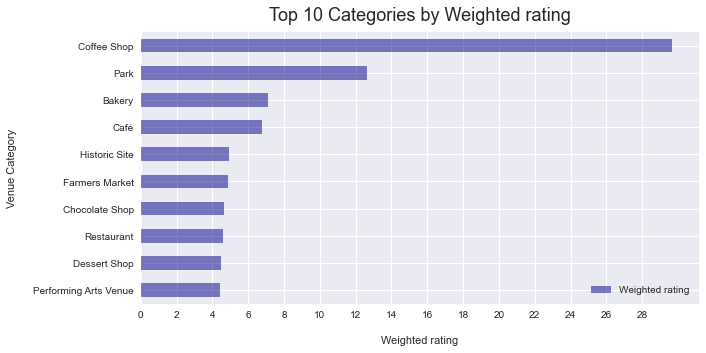

In [201]:

# Sorting by Rating
sort_rate = standardized_1.sort_values("Weighted rating", ascending=True)

# Creating bar chart
sort_rate[-10:].plot(kind='barh',x='Venue Category', y='Weighted rating', color="Darkblue", alpha=0.5, figsize=(10, 5), xticks=np.arange(0, 30, 2))

plt.xlabel("Weighted rating", labelpad=16)
plt.ylabel("Venue Category", labelpad=16)
plt.title("Top 10 Categories by Weighted rating", y=1.02, fontsize=18)



### Lets dig deeper into the data to determine the locations of high rated restaurants

In [202]:
# Create a copy of the Toronto_data for clustering 
Toronto_group_clustering = standardized_1.copy()

In [203]:
# Drop catagorical data before clustering 
Toronto_group_clustering = Toronto_group_clustering.drop(['Venue Category'], axis = 1)

# Clustering the Toronto Restaurant Data

#### Find the centriods for KMeans

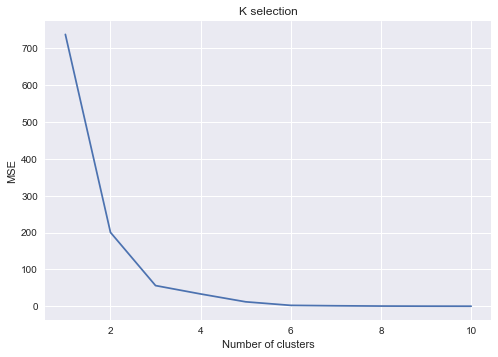

In [204]:
%matplotlib inline
plt.style.use("seaborn")
Ks = 11
mse = np.zeros((Ks-1))
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(Toronto_group_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()


##### According to the graph above the optimal value is found to be 3

In [205]:
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_group_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [207]:
# add clustering labels to toronto_venue 
standardized_1.insert(3, 'Cluster Labels', kmeans.labels_)

standardized_1


,Standardized Counts,Venue Category,Rating,Cluster Labels,Latitude,Longitude,Weighted rating
0,0.527504,Historic Site,9.3,0,-79.3606,43.6543,4.90579
1,0.527504,Farmers Market,9.2,0,-79.3606,43.6543,4.85304
2,0.527504,Chocolate Shop,8.8,0,-79.3606,43.6543,4.64204
3,0.527504,Restaurant,8.7,0,-79.3606,43.6543,4.58929
4,0.527504,Dessert Shop,8.5,0,-79.3606,43.6543,4.48379
5,0.527504,Performing Arts Venue,8.4,0,-79.3606,43.6543,4.43104
6,0.527504,Distribution Center,8.3,0,-79.3606,43.6543,4.37829
7,0.857195,Bakery,8.26667,0,-79.3606,43.6543,7.08614
8,0.527504,French Restaurant,8.2,0,-79.3606,43.6543,4.32554
9,3.62659,Coffee Shop,8.18571,1,-79.3542,43.6645,29.6863


In [221]:
grouped_data=toronto_venues.groupby('Venue Category')
grouped_data.first()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Rating
Venue Category,,,,,,,,
Bakery,Harbourfront,43.654260,-79.360636,54ea41ad498e9a11e9e13308,Roselle Desserts,43.653447,-79.362017,9.0
Breakfast Spot,Harbourfront,43.654260,-79.360636,4ae5b91ff964a520a6a121e3,Morning Glory Cafe,43.653947,-79.361149,7.5
Café,Harbourfront,43.654260,-79.360636,54d37e23498e5e29bcb35362,ODIN Cafe + Bar,43.656739,-79.356503,7.9
Chocolate Shop,Harbourfront,43.654260,-79.360636,4b0978e1f964a520cd1723e3,SOMA chocolatemaker,43.650622,-79.358127,8.8
Coffee Shop,Victoria Village,43.725882,-79.315572,4bbe904a85fbb713420d7167,Tim Hortons,43.725517,-79.313103,6.0
Dessert Shop,Harbourfront,43.654260,-79.360636,5653a96f498e99c91027730b,Cacao 70,43.650067,-79.360723,8.5
Distribution Center,Harbourfront,43.654260,-79.360636,574c229e498ebb5c6b257902,Cooper Koo Family YMCA,43.653249,-79.358008,8.3
Farmers Market,Harbourfront,43.654260,-79.360636,4c3e1eaa6faac9b66dc60d76,Distillery Sunday Market,43.650075,-79.361832,9.2
Food Truck,Harbourfront,43.654260,-79.360636,4fa7ebe5a17c43f4427e572b,Buster's Sea Cove Truck,43.653647,-79.357878,7.0


In [226]:
merged_data=pd.merge(standardized_1, toronto_venues, on='Venue Category', how='left')
merged_data.head()

,Standardized Counts,Venue Category,Rating_x,Cluster Labels,Latitude,Longitude,Weighted rating,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Rating_y
0,0.527504,Historic Site,9.3,0,-79.3606,43.6543,4.90579,Harbourfront,43.65426,-79.360636,4ad4c05ef964a520bff620e3,The Distillery Historic District,43.650244,-79.359323,9.3
1,0.527504,Farmers Market,9.2,0,-79.3606,43.6543,4.85304,Harbourfront,43.65426,-79.360636,4c3e1eaa6faac9b66dc60d76,Distillery Sunday Market,43.650075,-79.361832,9.2
2,0.527504,Chocolate Shop,8.8,0,-79.3606,43.6543,4.64204,Harbourfront,43.65426,-79.360636,4b0978e1f964a520cd1723e3,SOMA chocolatemaker,43.650622,-79.358127,8.8
3,0.527504,Restaurant,8.7,0,-79.3606,43.6543,4.58929,Harbourfront,43.65426,-79.360636,5612b1cc498e3dd742af0dc8,Impact Kitchen,43.656369,-79.356980,8.7
4,0.527504,Dessert Shop,8.5,0,-79.3606,43.6543,4.48379,Harbourfront,43.65426,-79.360636,5653a96f498e99c91027730b,Cacao 70,43.650067,-79.360723,8.5


In [241]:
#Drop rating_y
merge_drop= merged_data.drop ('Rating_y',axis=1)
merge_drop.head()

,Standardized Counts,Venue Category,Rating_x,Cluster Labels,Latitude,Longitude,Weighted rating,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude
0,0.527504,Historic Site,9.3,0,-79.3606,43.6543,4.90579,Harbourfront,43.65426,-79.360636,4ad4c05ef964a520bff620e3,The Distillery Historic District,43.650244,-79.359323
1,0.527504,Farmers Market,9.2,0,-79.3606,43.6543,4.85304,Harbourfront,43.65426,-79.360636,4c3e1eaa6faac9b66dc60d76,Distillery Sunday Market,43.650075,-79.361832
2,0.527504,Chocolate Shop,8.8,0,-79.3606,43.6543,4.64204,Harbourfront,43.65426,-79.360636,4b0978e1f964a520cd1723e3,SOMA chocolatemaker,43.650622,-79.358127
3,0.527504,Restaurant,8.7,0,-79.3606,43.6543,4.58929,Harbourfront,43.65426,-79.360636,5612b1cc498e3dd742af0dc8,Impact Kitchen,43.656369,-79.356980
4,0.527504,Dessert Shop,8.5,0,-79.3606,43.6543,4.48379,Harbourfront,43.65426,-79.360636,5653a96f498e99c91027730b,Cacao 70,43.650067,-79.360723


In [233]:
merge_drop.rename(columns={'Rating_x':'Rating'}, inplace=True)
finalized_data=merge_drop

In [238]:
# Examining the clusters
cluster_1=finalized_data.loc[finalized_data['Cluster Labels'] == 0, finalized_data.columns[[0] + list(range(1, finalized_data.shape[1]))]]
cluster_1_sorted=cluster_1.sort_values(by='Weighted rating', ascending=False)
cluster_1_sorted.head()

,Standardized Counts,Venue Category,Rating,Cluster Labels,Latitude,Longitude,Weighted rating,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude
7,0.857195,Bakery,8.26667,0,-79.3606,43.6543,7.08614,Harbourfront,43.65426,-79.360636,54ea41ad498e9a11e9e13308,Roselle Desserts,43.653447,-79.362017
9,0.857195,Bakery,8.26667,0,-79.3606,43.6543,7.08614,Harbourfront,43.65426,-79.360636,4ad4c05df964a5204ef620e3,The Sweet Escape Patisserie,43.650632,-79.358709
8,0.857195,Bakery,8.26667,0,-79.3606,43.6543,7.08614,Harbourfront,43.65426,-79.360636,4b156a02f964a5207fac23e3,Brick Street Bakery,43.650574,-79.359539
24,0.857195,Café,7.9,0,-79.3606,43.6543,6.77184,Harbourfront,43.65426,-79.360636,583e2cde9435a913b34de355,Wildly Delicious Cafe,43.650436,-79.358862
23,0.857195,Café,7.9,0,-79.3606,43.6543,6.77184,Harbourfront,43.65426,-79.360636,4d84d98181fdb1f7d4a704c0,Caffe Furbo,43.649970,-79.358849


In [235]:
finalized_data.loc[finalized_data['Cluster Labels'] == 1, finalized_data.columns[[0] + list(range(1, finalized_data.shape[1]))]]

,Standardized Counts,Venue Category,Rating,Cluster Labels,Latitude,Longitude,Weighted rating,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude
11,3.62659,Coffee Shop,8.18571,1,-79.3542,43.6645,29.6863,Victoria Village,43.725882,-79.315572,4bbe904a85fbb713420d7167,Tim Hortons,43.725517,-79.313103
12,3.62659,Coffee Shop,8.18571,1,-79.3542,43.6645,29.6863,Harbourfront,43.654260,-79.360636,53b8466a498e83df908c3f21,Tandem Coffee,43.653559,-79.361809
13,3.62659,Coffee Shop,8.18571,1,-79.3542,43.6645,29.6863,Harbourfront,43.654260,-79.360636,51853a73498e4d97a8b20831,Rooster Coffee,43.651900,-79.365609
14,3.62659,Coffee Shop,8.18571,1,-79.3542,43.6645,29.6863,Harbourfront,43.654260,-79.360636,57cd9d20498e6ab8342980e2,Arvo,43.649963,-79.361442
15,3.62659,Coffee Shop,8.18571,1,-79.3542,43.6645,29.6863,Harbourfront,43.654260,-79.360636,58c7fbf7424f9373e6427e99,Starbucks,43.651613,-79.364917
16,3.62659,Coffee Shop,8.18571,1,-79.3542,43.6645,29.6863,Harbourfront,43.654260,-79.360636,5619551a498e9e35fce2256b,Sumach Espresso,43.658135,-79.359515
17,3.62659,Coffee Shop,8.18571,1,-79.3542,43.6645,29.6863,Harbourfront,43.654260,-79.360636,581258b738fa5bbefe4c0857,Dark Horse Espresso Bar,43.653081,-79.357078


In [236]:
finalized_data.loc[finalized_data['Cluster Labels'] == 2, finalized_data.columns[[0] + list(range(1, finalized_data.shape[1]))]]

,Standardized Counts,Venue Category,Rating,Cluster Labels,Latitude,Longitude,Weighted rating,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude
18,1.54954,Park,8.15,2,-79.3529,43.679,12.6288,Parkwoods,43.753259,-79.329656,4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,43.751976,-79.332140
19,1.54954,Park,8.15,2,-79.3529,43.679,12.6288,Harbourfront,43.654260,-79.360636,51ccc048498ec7792efc955e,Corktown Common,43.655618,-79.356211
20,1.54954,Park,8.15,2,-79.3529,43.679,12.6288,Harbourfront,43.654260,-79.360636,4ddfbaca185035f3a44e8df6,Underpass Park,43.655764,-79.354806
21,1.54954,Park,8.15,2,-79.3529,43.679,12.6288,Harbourfront,43.654260,-79.360636,4c16a548955976b0cadea4f6,Parliament Square Park,43.650264,-79.362195


#### Lets visualize the clusters

In [240]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(finalized_data['Venue Latitude'], finalized_data['Venue Longitude'], finalized_data['Neighborhood'], finalized_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Methodology:¶
         
####         After data gathering and cleaning, data visualization was performed to glean basic intuition about the most popular restaurant categories. Subsequently elbow method was used to determine the number of clusters that would most accurately assess the data. Kmeans was initiated in order to gather deeper insights from the data at hand.

# Results and Discussion¶
      
####      After using the visual tools to analyze data, burrito places and cafes were found to be two of the most popular categories of eateries. As information on ratings of only one of each type has been retrieved by foursquare, there isnt enough data to provide a conclusive assessment. However the ratings are indicative of affinity of people for these venues and can be used as a marker to further glean from these eateries, information which has been contributing to their success.

####       Further analysis through K means revealed that the Ryerson neighborhood, belonging to cluster has the most popular restaurants. Due to foursquare account related api restrictions, information of other neighborhoods could not be acquired. It would’ve surely led to a more comprehensive assessment.

# Conclusion

#### In conclusion through clustering various toronto locations containing restaurants having varying ratings, Ryerson neighborhood of Toronto was found to concentrate the most popular restaurants. On analysis of data done prior to clustering it was also found that burrito places and cafes are two of the highest rated restaurants venue categories. While further investigation is needed to acquire details of the most popular restaurants, such as their best selling items and management strategies. A more comprehensive research to determine ratings of other venues of similar category as well as popular eateries of other neighbourhoods of Toronto. Development of plans for establishment of eateries that are unlikely be swayed by the results of additional investigations can be set in place.